In [1]:
import numpy as np
import pandas as pd
import gzip
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD

from textblob import TextBlob


import string
import re
from nltk.stem.porter import PorterStemmer

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# 1. Listing Data Preparation
We are using (San Diego, latest scraped data 2019-11-21) for exploration purpose.

## 1.1 General Exploration & Data Cleaning

In [2]:
listings = pd.read_csv("http://data.insideairbnb.com/united-states/ca/san-diego/2019-11-21/data/listings.csv.gz",
                     compression='gzip',
                     low_memory=False)
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,https://www.airbnb.com/rooms/5570,20191121092222,2019-11-21,Ocean front condo on the sand,Missionbeachretreat. Great Ocean Front Condo...,This charming two bedroom beachfront condomini...,Missionbeachretreat. Great Ocean Front Condo...,none,While some may compare San Diego’s Mission Bea...,NaN,Bus #8 goes to La Jolla and Old Town transit c...,"2 Bedrooms (1 Queen, 2 Twins) 1 Bath Balcony ...",Once reservation is made I will call guest. I...,"Min 4 nights winter. 7 nights Spring Break, l...",NaN,NaN,https://a0.muscache.com/im/pictures/d3342744-1...,NaN,8435,https://www.airbnb.com/users/show/8435,Jef Karchin,2009-02-23,"San Diego, California, United States","Real estate broker, Jef Karchin real estate ...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/users/8435/profile_...,https://a0.muscache.com/im/users/8435/profile_...,Mission Beach,3.0,3.0,"['email', 'phone', 'kba']",t,t,"San Diego, CA, United States",Mission Beach,Mission Bay,NaN,San Diego,CA,92109,San Diego,"San Diego, CA",US,United States,32.78430,-117.25258,t,Condominium,Entire home/apt,6,1.0,2.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",850.0,"$2,050.00",NaN,NaN,$500.00,$150.00,1,$0.00,3,365,3,3,365,365,3.0,365.0,2 months ago,t,12,20,31,176,2019-11-21,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,"{""SAN DIEGO"","" SAN DIEGO TOURISM MARKETING DIS...",f,f,strict_14_with_grace_period,f,f,2,2,0,0,NaN
1,8488,https://www.airbnb.com/rooms/8488,20191121092222,2019-11-21,Juniper Zen Palace- SD's Best Hood!,Walk every where in San Diegos most charming a...,Private craftsman home in the heart of Histori...,Walk every where in San Diegos most charming a...,none,South Park is a charming community and our nei...,we have no cable tv. just streaming services. ...,bus route to downtown is 1/2 block away!,backyard,NaN,"• Check-in time is 3PM. We are fun, easygoing ...",NaN,NaN,https://a0.muscache.com/im/pictures/b1f12e62-1...,NaN,25186,https://www.airbnb.com/users/show/25186,Helene,2009-07-10,"Los Angeles, California, United States",HI! I am a photographer on tour. I have severa...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/b83cc...,https://a0.muscache.com/im/pictures/user/b83cc...,Burlingame,4.0,4.0,"['email', 'pho

In [3]:
print("Number of rows: " + str(listings.shape[0]))
print("Number of columns: " + str(listings.shape[1]))

Number of rows: 13574
Number of columns: 106


In [4]:
## Use profile() to quickly explore the variables, including their values, ranges, mean, NA's, correlations, etc.
#profile = ProfileReport(listings)
#profile

## 1.2 Explore price

* We aggregated the Calender data by season, and noticed that the averaged price is very similar to the Listing price, so we decide to use the Listing price as it serves our purpose in this project and fairly accurate.
* There is no NA.
* Heavy tail. And there are some outliers. Maximum price is 10000 per night, and 99 quantile of price is 1500. After clicking open some Airbnb pages and based on common judgement, we decided to remove properties with price greater than $1000 from the list for now. -> 1.97% of the data was removed

In [5]:
listings.price = list(map(lambda x:float(str(x).replace("$", "").replace(",", "")), listings.price))
listings.price.describe()

count    13574.000000
mean       235.546412
std        509.094669
min          0.000000
25%         82.000000
50%        135.000000
75%        249.000000
max      10000.000000
Name: price, dtype: float64

In [6]:
listings = listings.loc[(listings['price'] > 0) & (listings['price'] < 1000)]
print("Number of rows: " + str(listings.shape[0]))

Number of rows: 13306


/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


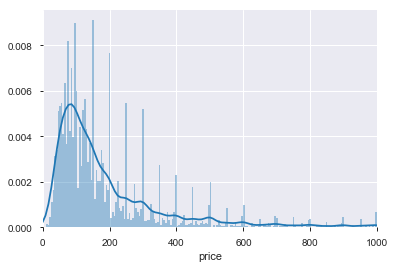

In [7]:
sns.distplot(listings.price, bins = 200)
plt.xlim(0, 1000)
plt.show()

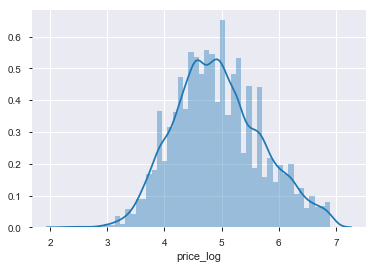

In [8]:
listings['price_log'] = np.log(listings.price)
sns.distplot(listings['price_log'])

## 1.3 Explore Occupancy

* No NA
* Very interesting visualization: shows polarization and high demand. Worth further investigation!

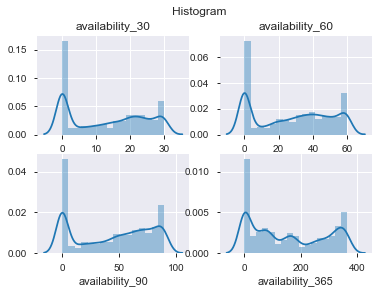

In [9]:
fig, axs = plt.subplots(ncols=2, nrows = 2)
fig.suptitle('Histogram')
sns.distplot(listings.availability_30, ax=axs[0,0]).set_title("availability_30")
sns.distplot(listings.availability_60, ax=axs[0,1]).set_title("availability_60")
sns.distplot(listings.availability_90, ax=axs[1,0])
sns.distplot(listings.availability_365, ax=axs[1,1])

In [10]:
listings = listings.loc[(listings['availability_365'] > 0) & (listings['availability_90'] < 90)]
listings.shape

(9915, 107)

## 1.4 Explore House Information Variables
#### Including: city,	state,	zipcode, property_type,	room_type,	accommodates,	bathrooms,	bedrooms,	beds,	bed_type, etc.

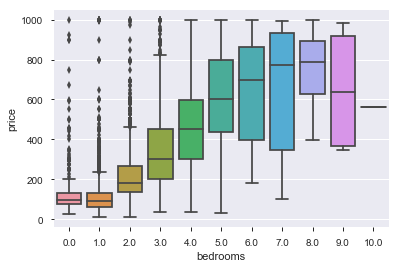

In [11]:
ax = sns.boxplot(x='bedrooms', y='price', data=listings)

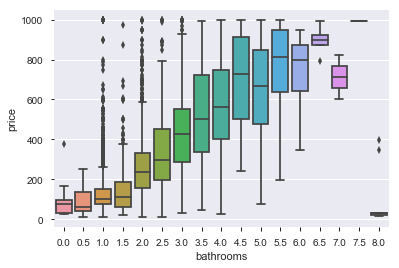

In [12]:
ax2 = sns.boxplot(x='bathrooms', y='price', data=listings)

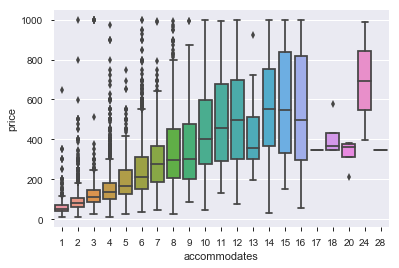

In [13]:
ax3 = sns.boxplot(x='accommodates', y='price', data=listings)

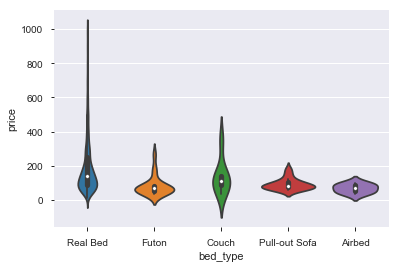

In [14]:
sns.violinplot(x='bed_type', y='price', data=listings)

In [15]:
neighborhood_from_listings = listings[['id', 'neighbourhood_cleansed']]
neighborhood_from_listings.head()

,id,neighbourhood_cleansed
1,8488,South Park
2,29967,Pacific Beach
3,38245,Roseville
4,39516,North Hills
6,54001,La Jolla


In [16]:
set(listings['property_type'])

{'Aparthotel',
 'Apartment',
 'Barn',
 'Bed and breakfast',
 'Boat',
 'Boutique hotel',
 'Bungalow',
 'Bus',
 'Cabin',
 'Camper/RV',
 'Casa particular (Cuba)',
 'Castle',
 'Cave',
 'Chalet',
 'Condominium',
 'Cottage',
 'Dome house',
 'Earth house',
 'Farm stay',
 'Guest suite',
 'Guesthouse',
 'Hostel',
 'Hotel',
 'House',
 'Hut',
 'Loft',
 'Nature lodge',
 'Other',
 'Resort',
 'Serviced apartment',
 'Tent',
 'Tiny house',
 'Townhouse',
 'Treehouse',
 'Vacation home',
 'Villa'}

In [17]:
set(listings['city'])

{' La Jolla',
 ' San Diego',
 'Ajijic',
 'Alpine',
 'Bonita',
 'CA',
 'Chula Vista',
 'Chula Vista ',
 'Chula Vista (Eastlake)',
 'Del Mar',
 'Escondido',
 'Gas lamp San Diego',
 'Imperial Beach',
 'La Jolla',
 'La Jolla ',
 'La Jolla Cove',
 'La Mesa',
 'Lemon Grove',
 'Mission Bay',
 'Mission Beach',
 'National City',
 'Ocean Beach',
 'Oceanside',
 'SAN DIEGO',
 'San Deigo',
 'San Diego',
 'San Diego ',
 'San Diego County',
 'San Diego, California, US',
 'San diego',
 'Santee',
 'Solana Beach',
 'Sugarloaf',
 'Tijuana'}

## 1.5 Explore Geo Data

###### Map (Method I)

In [69]:
import geopandas as gpd

# set the filepath and load in a shapefile
fp = 'http://data.insideairbnb.com/united-states/ca/san-diego/2020-02-22/visualisations/neighbourhoods.geojson'
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Amphitheater And Water Park,None,"(POLYGON ((-117.014515 32.587899, -117.014488 ..."
1,Bella Lago,None,"(POLYGON ((-116.941279 32.684306, -116.941278 ..."
2,Bonita Long Canyon,None,"(POLYGON ((-117.011489 32.663525, -117.011489 ..."
3,East Lake,None,"(POLYGON ((-116.993021 32.660396, -116.98164 3..."
4,Eastlake Trails,None,"(POLYGON ((-116.955116 32.641243, -116.95507 3..."


In [70]:
frame_geo = listings.groupby('neighbourhood_cleansed')['price'].mean().reset_index(name='average_price')
frame_geo['neighbourhood'] = frame_geo['neighbourhood_cleansed']

In [71]:
merged = pd.merge(map_df, frame_geo, on = 'neighbourhood', how="left")

merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]

merged.sort_values(by = 'average_price', ascending = False)

,neighbourhood,neighbourhood_group,geometry,neighbourhood_cleansed,average_price,coords
54,Horton Plaza,None,"(POLYGON ((-117.165801 32.712727, -117.165773 ...",Horton Plaza,371.000000,"(-117.16435664983119, 32.714773)"
16,Rancho Del Rey,None,"(POLYGON ((-117.036521 32.646577, -117.036179 ...",Rancho Del Rey,369.571429,"(-117.01787015441946, 32.644870499999996)"
60,La Jolla,None,"(POLYGON ((-117.2823 32.839309, -117.282036 32...",La Jolla,339.997085,"(-117.25770739116884, 32.838491000000005)"
107,Wooded Area,None,"(POLYGON ((-117.258564 32.725764, -117.258545 ...",Wooded Area,337.673469,"(-117.24725704802053, 32.6970635)"
70,Mission Bay,None,"(POLYGON ((-117.245845 32.7575, -117.245845 32...",Mission Bay,329.476545,"(-116.98854215703966, 32.567321500000006)"
102,Torrey Pines,None,"(POLYGON ((-117.262145 32.939336, -117.261182 ...",Torrey Pines,327.437500,"(-117.23936868831169, 32.904545)"
43,Del Mar Heights,None,"(POLYGON ((-117.260955 32.9481, -117.260427 32...",Del Mar Heights,300.578125,"(-117.25041491909226, 32.9562315)"
17,Rolling Hills Ranch,None,"(POLYGON ((-116.971367 32.657932, -116.971276 ...",Rolling Hills Ranch,294.700000,"(-116.95867360946895, 32.6673095)"
22,Terra Nova,None,"(POLYGON ((-117.055587 32.640424, -117.055212 ...",Terra Nova,291.666667,"(-117.04435358388844, 32.642457)"
2,Bonita Long Canyon,None,"(POLYGON ((-117.011489 32.663525, -117.011489 ...",Bonita Long Canyon,255.000000,"(-117.00036417910891, 32.657165500000005)"


In [72]:
#merged_ = merged
#merged_['average_price'].loc[merged_['neighbourhood'] == 'Mission Bay'] = 0

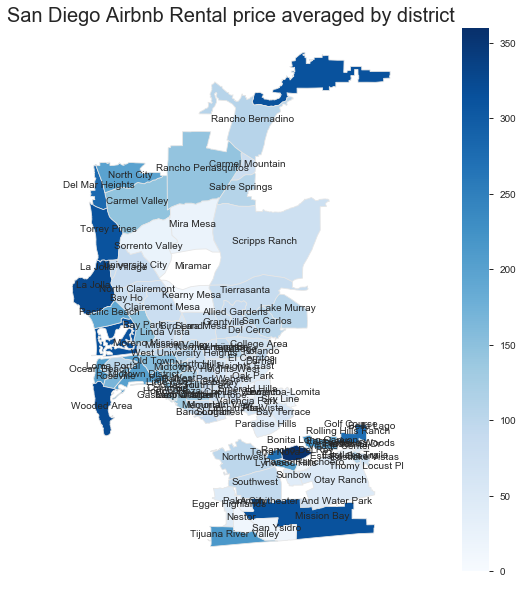

In [73]:
# set a variable that will call the column we want to visualise on the map
variable = 'average_price'
# set the range for the choropleth
vmin, vmax = 0, 360
# create figure and axes for Matplotlib

fig, ax = plt.subplots(1, figsize=(20, 10))
merged.plot(column='average_price', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.9')

for idx, row in merged.iterrows():
    plt.annotate(s=row['neighbourhood'], xy=row['coords'],
                 horizontalalignment='center')

#merged.apply(lambda x: ax.annotate(s=x.neighbourhood, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

ax.axis('off')
# add a title
ax.set_title('San Diego Airbnb Rental price averaged by district', fontdict={'fontsize': '20', 'fontweight' : '3'})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [74]:
frame_geo2 = listings.groupby('neighbourhood_cleansed')['id'].count().reset_index(name='id_count')
frame_geo2['neighbourhood'] = frame_geo2['neighbourhood_cleansed']

merged2 = pd.merge(map_df, frame_geo2, on = 'neighbourhood')

merged2['coords'] = merged2['geometry'].apply(lambda x: x.representative_point().coords[:])
merged2['coords'] = [coords[0] for coords in merged2['coords']]
merged2.sort_values('id_count', ascending= False)

,neighbourhood,neighbourhood_group,geometry,neighbourhood_cleansed,id_count,coords
64,Mission Bay,None,"(POLYGON ((-117.245845 32.7575, -117.245845 32...",Mission Bay,1343,"(-116.98854215703966, 32.567321500000006)"
76,Pacific Beach,None,"(POLYGON ((-117.262686 32.805324, -117.261027 ...",Pacific Beach,801,"(-117.23892886538462, 32.807836)"
55,La Jolla,None,"(POLYGON ((-117.2823 32.839309, -117.282036 32...",La Jolla,686,"(-117.25770739116884, 32.838491000000005)"
39,East Village,None,"(POLYGON ((-117.153788 32.696526, -117.160511 ...",East Village,678,"(-117.15350365947012, 32.7093635)"
72,North Hills,None,"(POLYGON ((-117.147773 32.745145, -117.146418 ...",North Hills,532,"(-117.13373431569428, 32.745881499999996)"
53,Midtown,None,"(POLYGON ((-117.182359 32.742454, -117.181273 ...",Midtown,499,"(-117.1647458105443, 32.742859)"
74,Ocean Beach,None,"(POLYGON ((-117.257318 32.733364, -117.257309 ...",Ocean Beach,399,"(-117.25029396238097, 32.740700000000004)"
16,Balboa Park,None,"(POLYGON ((-117.15949 32.736765, -117.158816 3...",Balboa Park,255,"(-117.14445587152846, 32.728359999999995)"
61,Loma Portal,None,"(POLYGON ((-117.249118 32.743064, -117.242273 ...",Loma Portal,242,"(-117.2335304241134, 32.744114499999995)"
60,Little Italy,None,"(POLYGON ((-117.174991 32.723209, -117.175009 ...",Little Italy,205,"(-117.17023368253247, 32.7255905)"


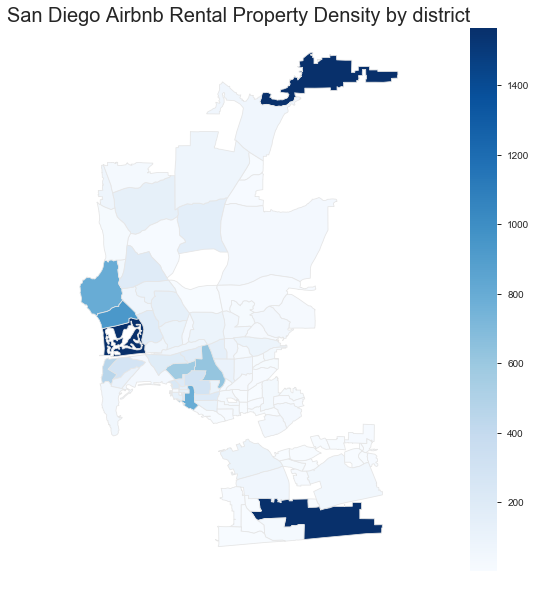

In [75]:
# set a variable that will call the column we want to visualise on the map
variable = 'id_count'
# set the range for the choropleth
vmin, vmax = 1, 1565
# create figure and axes for Matplotlib

fig, ax = plt.subplots(1, figsize=(20, 10))
merged2.plot(column='id_count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.9')
#for idx, row in merged.iterrows():
#    plt.annotate(s=row['neighbourhood'], xy=row['coords'],
#                 horizontalalignment='center')
ax.axis('off')
# add a title
ax.set_title('San Diego Airbnb Rental Property Density by district', fontdict={'fontsize': '20', 'fontweight' : '3'})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

###### Map (Method II)

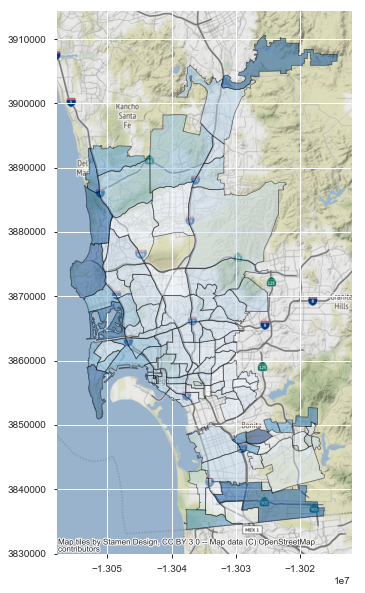

In [76]:
import contextily as ctx

df = merged
df = df.to_crs(epsg=3857)

ax = df.plot(column='average_price', cmap='Blues', linewidth=0.8, figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

###### Map (Method III)
Not working yet

In [77]:
from geopandas.tools import sjoin
import folium
from folium.plugins import MarkerCluster
#from folium.element import IFrame
import shapely
import pysal as ps

crime_map = folium.Map([35.7556, -117.4399], zoom_start = 12)
folium.Map([32.9, -116.8], zoom_start = 10)

In [78]:
merged['id'] = range(1, merged.shape[0]+1)
def add_choropleth(mapobj, gdf, id_field, value_field, fill_color = 'YlOrRd', fill_opacity = 0.6, 
                    line_opacity = 0.2, num_classes = 5, classifier = 'Fisher_Jenks'):
    #Allow for 3 Pysal map classifiers to display data
    #Generate list of breakpoints using specified classification scheme. List of breakpoint will be input to choropleth function
    if classifier == 'Fisher_Jenks':
        threshold_scale=ps.esda.mapclassify.Fisher_Jenks(gdf[value_field], k = num_classes).bins.tolist()
    if classifier == 'Equal_Interval':
        threshold_scale=ps.esda.mapclassify.Equal_Interval(gdf[value_field], k = num_classes).bins.tolist()
    if classifier == 'Quantiles':
        threshold_scale=ps.esda.mapclassify.Quantiles(gdf[value_field], k = num_classes).bins.tolist()
    
    #Convert the GeoDataFrame to WGS84 coordinate reference system
    gdf_wgs84 = gdf.to_crs({'init': 'epsg:4326'})
    
    #Call Folium choropleth function, specifying the geometry as a the WGS84 dataframe converted to GeoJSON, the data as 
    #the GeoDataFrame, the columns as the user-specified id field and and value field.
    #key_on field refers to the id field within the GeoJSON string
    mapobj.choropleth(geo_str = gdf_wgs84.to_json(), data = gdf,
                columns = [id_field, value_field], key_on = 'feature.properties.{}'.format(id_field),
                fill_color = fill_color, fill_opacity = fill_opacity, line_opacity = line_opacity,  
                threshold_scale = threshold_scale)
    return mapobj

#Update basemap with choropleth
crime_map=add_choropleth(crime_map, merged, 'id','average_price')

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' f

TypeError: __init__() missing 1 required positional argument: 'geo_data'

## 1.6 Explore Descriptive Variables 
#### Including: name,	summary,	space,	description,	experiences_offered,	neighborhood_overview,	notes,	transit,	access,	interaction,	house_rules,	thumbnail_url,	medium_url,	picture_url,	xl_picture_url

* No NA in name
* Very few NA in summary, description <2%
* High percent of NA in other variables
* Exclude experiences_offered (constant), and all urls

In [22]:
print("# NA in name: " + str(listings.name.isnull().sum()))
print("# NA in summary: " + str(round(listings.summary.isnull().sum()/listings.shape[0], 2)))
print("# NA in description: " + str(round(listings.description.isnull().sum()/listings.shape[0], 2)))
print("# NA in neighborhood_overview: " + str(round(listings.neighborhood_overview.isnull().sum()/listings.shape[0], 2)))
print("# NA in notes: " + str(round(listings.notes.isnull().sum()/listings.shape[0], 2)))
print("# NA in transit: " + str(round(listings.transit.isnull().sum()/listings.shape[0], 2)))
print("# NA in access: " + str(round(listings.access.isnull().sum()/listings.shape[0], 2)))
print("# NA in interaction: " + str(round(listings.interaction.isnull().sum()/listings.shape[0], 2)))
print("# NA in house_rules: " + str(round(listings.house_rules.isnull().sum()/listings.shape[0], 2)))

# NA in name: 0
# NA in summary: 0.03
# NA in description: 0.02
# NA in neighborhood_overview: 0.25
# NA in notes: 0.41
# NA in transit: 0.34
# NA in access: 0.35
# NA in interaction: 0.3
# NA in house_rules: 0.22


In [23]:
listings = listings.drop(['experiences_offered','thumbnail_url','medium_url','picture_url','xl_picture_url'], axis=1)
print("Number of columns: " + str(listings.shape[1]))

Number of columns: 102


### Basic Features
Don't think we need this many variables. Maybe 
* combine some together OR delete some
* try different normalization rather than divide by length
* change to 1/0
* log transform

###### Length

In [24]:
listings['name_len'] = listings.name.str.len()

listings['summary_len'] = listings.summary.str.len()
listings.loc[listings['summary_len'].isnull(), 'summary_len'] = 0

listings['description_len'] = listings.description.str.len()
listings.loc[listings['description_len'].isnull(), 'description_len'] = 0

listings['neighborhood_overview_len'] = listings.neighborhood_overview.str.len()
listings.loc[listings['neighborhood_overview_len'].isnull(), 'neighborhood_overview_len'] = 0

listings['notes_len'] = listings.notes.str.len()
listings.loc[listings['notes_len'].isnull(), 'notes_len'] = 0

listings['transit_len'] = listings.transit.str.len()
listings.loc[listings['transit_len'].isnull(), 'transit_len'] = 0

listings['access_len'] = listings.access.str.len()
listings.loc[listings['access_len'].isnull(), 'access_len'] = 0

listings['interaction_len'] = listings.interaction.str.len()
listings.loc[listings['interaction_len'].isnull(), 'interaction_len'] = 0

listings['house_rules_len'] = listings.house_rules.str.len()
listings.loc[listings['house_rules_len'].isnull(), 'house_rules_len'] = 0

listings[['neighborhood_overview_len', 'neighborhood_overview']].head()

,neighborhood_overview_len,neighborhood_overview
1,124.0,South Park is a charming community and our nei...
2,0.0,NaN
3,281.0,"This neighborhood is an expensive, high-end Po..."
4,314.0,"We love our eclectic neighborhood, with a smal..."
6,354.0,"Tranquility, stately trees, meditative, zen-fu..."


###### #special characters / length

In [25]:
listings['name_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['name']] / listings['name_len']
listings['summary_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['summary']] / listings['summary_len']
listings['description_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['description']] / listings['description_len']
listings['neighborhood_overview_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['neighborhood_overview']] / listings['neighborhood_overview_len']
listings['notes_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['notes']] / listings['notes_len']
listings['transit_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['transit']] / listings['transit_len']
listings['access_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['access']] / listings['access_len']
listings['interaction_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['interaction']] / listings['interaction_len']
listings['house_rules_spec'] = [len(re.sub('[A-Za-z0-9\s]+', '', str(x))) for x in listings['house_rules']] / listings['house_rules_len']

listings[['neighborhood_overview_spec', 'neighborhood_overview']].head()

,neighborhood_overview_spec,neighborhood_overview
1,0.024194,South Park is a charming community and our nei...
2,NaN,NaN
3,0.039146,"This neighborhood is an expensive, high-end Po..."
4,0.035032,"We love our eclectic neighborhood, with a smal..."
6,0.056497,"Tranquility, stately trees, meditative, zen-fu..."


Remove special characters

In [26]:
listings['name'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['name']]
listings['summary'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['summary']]
listings['description'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['description']]
listings['neighborhood_overview'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['neighborhood_overview']]
listings['notes'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['notes']]
listings['transit'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['transit']]
listings['access'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['access']]
listings['interaction'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['interaction']]
listings['house_rules'] = [re.sub('[^A-Za-z0-9]+', ' ', str(x)) for x in listings['house_rules']]

listings.name[10]

'Winter Rates 30 Seconds from your Bed 2 the Beach '

###### #Numbers

In [27]:
listings['name_num'] = listings['name'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['summary_num'] = listings['summary'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['description_num'] = listings['description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['neighborhood_overview_num'] = listings['neighborhood_overview'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['notes_num'] = listings['notes'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['transit_num'] = listings['transit'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['access_num'] = listings['access'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['interaction_num'] = listings['interaction'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
listings['house_rules_num'] = listings['house_rules'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

listings[['name_num','name']].head(10)

,name_num,name
1,0,Juniper Zen Palace SD s Best Hood
2,1,Great home 10 min walk to Beach
3,0,Point Loma Liberty Station NTC
4,0,Art Studio Retreat Rustic Cabin
6,0,La Jolla Peaceful Sitting Room Breakfast
7,0,charming colorful close to beach
8,0,Pacific Beach Cozy Private Unit Bikes Included
9,0,Canyon apartment hideaway
10,2,Winter Rates 30 Seconds from your Bed 2 the Be...
11,1,San Diego Living by JA 2


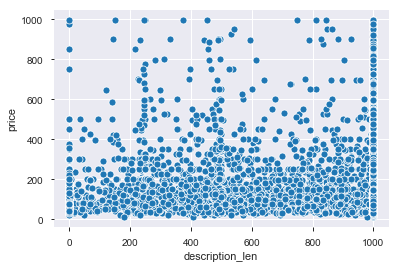

In [28]:
sns.scatterplot(y = 'price', x = 'description_len', data = listings)

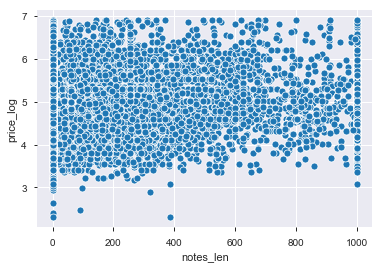

In [29]:
sns.scatterplot(y = 'price_log', x = 'notes_len', data = listings)

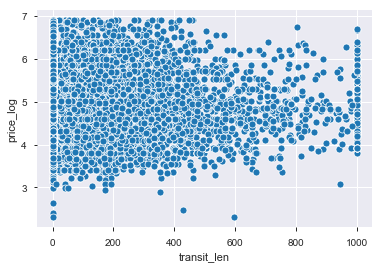

In [30]:
sns.scatterplot(y = 'price_log', x = 'transit_len', data = listings)

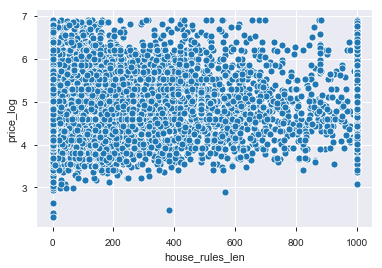

In [31]:
sns.scatterplot(y = 'price_log', x = 'house_rules_len', data = listings)

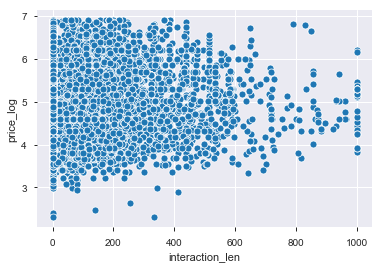

In [32]:
sns.scatterplot(y = 'price_log', x = 'interaction_len', data = listings)

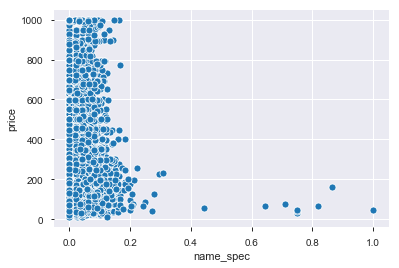

In [33]:
sns.scatterplot(y = 'price', x = 'name_spec', data = listings)

### TF-IDF
* High dimension, then what? PCA?
* NA: remove NA first and then add 0?

* Code: https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.XlvpGJNKhQI
https://www.bogotobogo.com/python/NLTK/tf_idf_with_scikit-learn_NLTK.php

In [34]:
## combine
listings['descriptC'] = (listings['name'] + " " + listings['description'] + " " +
                                listings['neighborhood_overview'] + " " + listings['notes'] + " " +
                                listings['transit'] + " " + listings['access'] + " " +
                                listings['interaction'] + " " + listings['house_rules'])
listings['descriptC'] = [re.sub('nan ', '', str(x)) for x in listings['descriptC']]

In [35]:
## remove numbers
regex_pat = re.compile("[^a-zA-Z]+")
listings.descriptC = listings.descriptC.str.replace(regex_pat, ' ')
## lower-case
listings['descriptC'] = listings['descriptC'].apply(lambda x: " ".join(x.lower() for x in x.split()))
## remove stop words
#nltk.download('stopwords')
stop = stopwords.words('english')
listings['descriptC'] = listings['descriptC'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
## stem
st = PorterStemmer()
listings['descriptC'] = listings['descriptC'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

listings.descriptC.head(10)

1     junip zen palac sd best hood walk everi san di...
2     great home min walk beach bedroom full bathroo...
3     point loma liberti station ntc stay spanish st...
4     art studio retreat rustic cabin love explor wo...
6     la jolla peac sit room breakfast peac one two ...
7     charm color close beach modern cozi artsi euro...
8     pacif beach cozi privat unit bike includ wonde...
9     canyon apart hideaway recent renov apart look ...
10    winter rate second bed beach nt guest winter s...
11    san diego live ja medium larg bedroom queen be...
Name: descriptC, dtype: object

In [36]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [37]:
#nltk.download('punkt')
tfidf_vectorizer=TfidfVectorizer(use_idf=True, tokenizer=tokenize, stop_words='english')

tfidf_descriptC=tfidf_vectorizer.fit_transform(listings.descriptC)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_w

In [38]:
descriptC_sdf = pd.SparseDataFrame(tfidf_vectorizer.fit_transform(listings['descriptC']),
                         columns = tfidf_vectorizer.get_feature_names(), 
                         default_fill_value = 0)
descriptC_sdf.shape

(9915, 15522)

In [39]:
## svd to reduce dimension
svd = TruncatedSVD(1)
descriptC_svd = svd.fit_transform(descriptC_sdf)
descriptC_svd.shape

(9915, 1)

In [40]:
listings['svd'] = descriptC_svd

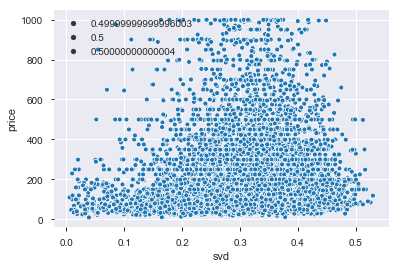

In [41]:
sns.scatterplot(y = 'price', x = 'svd', data = listings, size=0.5)

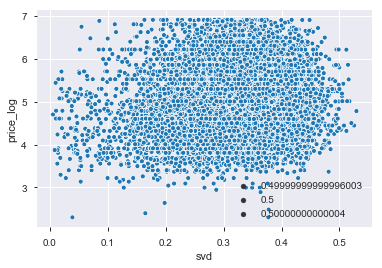

In [42]:
sns.scatterplot(y = 'price_log', x = 'svd', data = listings, size=0.5)

/Users/yuxinzhang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'whether host is superhost')

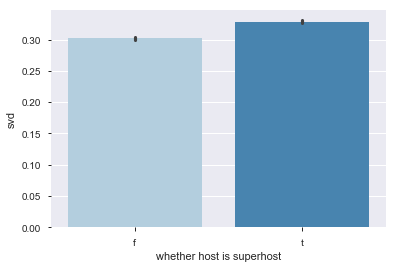

In [43]:
sns.barplot(x = 'host_is_superhost', y = 'svd', data = listings, palette = 'Blues')
plt.xlabel("whether host is superhost")

### Sentiment Analysis
* Polarity: [-1.0, 1.0]. 
* Subjectivity: [0.0, 1.0], where 0.0 is very objective and 1.0 is very subjective.

In [44]:
listings['descriptC_p'] = listings['descriptC'].apply(lambda x: TextBlob(x).sentiment[0])
listings['descriptC_s'] = listings['descriptC'].apply(lambda x: TextBlob(x).sentiment[1])

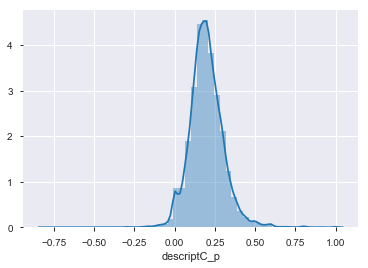

In [45]:
sns.distplot(listings['descriptC_p'])

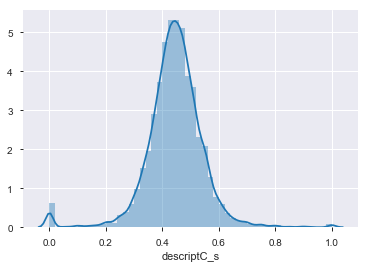

In [46]:
sns.distplot(listings['descriptC_s'])

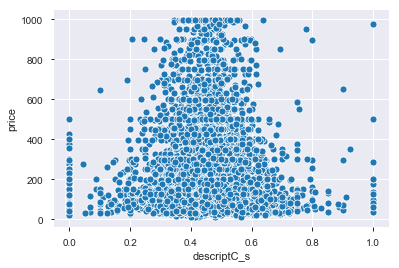

In [47]:
sns.scatterplot(x = "descriptC_s", y = "price", data = listings)

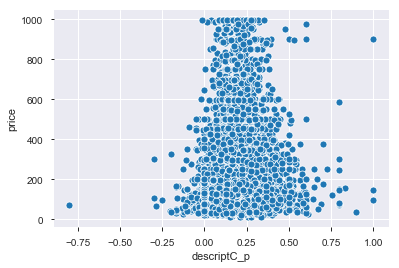

In [48]:
sns.scatterplot(x = "descriptC_p", y = "price", data = listings)

In [49]:
listings['descriptC'].loc[listings['descriptC_p'] < -0.5]

12591    joker choic privat room list one privat room b...
Name: descriptC, dtype: object

In [50]:
listings['house_rules_p'] = listings['house_rules'].apply(lambda x: TextBlob(x).sentiment[0])

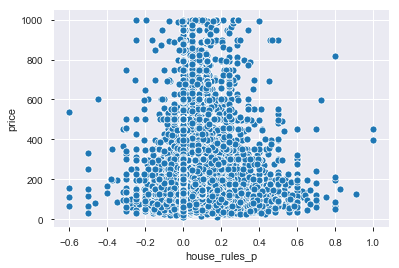

In [51]:
sns.scatterplot(x = "house_rules_p", y = "price", data = listings)

Text(0.5, 0, 'whether host is superhost')

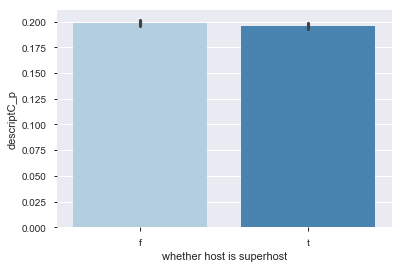

In [52]:
sns.barplot(x = 'host_is_superhost', y = 'descriptC_p', data = listings, palette = 'Blues')
plt.xlabel("whether host is superhost")

In [53]:
listings['house_rules'][62]

'Pets are not allowed It NOT ALLOWED to have parties And after 10 pm please lower the volume to respect our neighbors '

In [54]:
listings['house_rules'][9505]

'Guest should stack dirty dishes neatly at check out There are hardwood floors Shoes are allowed '

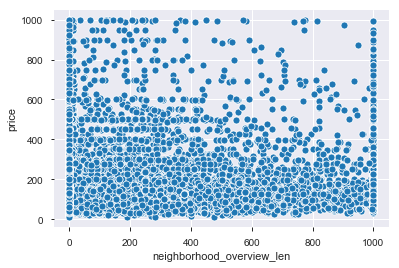

In [55]:
sns.scatterplot(x = "neighborhood_overview_len", y = "price", data = listings)

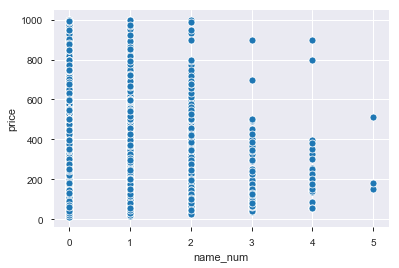

In [56]:
sns.scatterplot(y = "price", x = "name_num", data = listings)

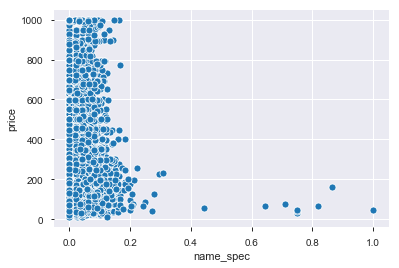

In [57]:
sns.scatterplot(y = "price", x = "name_spec", data = listings)

## 1.7 Explore Host Variables
#### Including: host_url,	host_name,	host_since,	host_location,	host_about,	host_response_time,	host_response_rate,	host_acceptance_rate,	host_is_superhost	, etc.

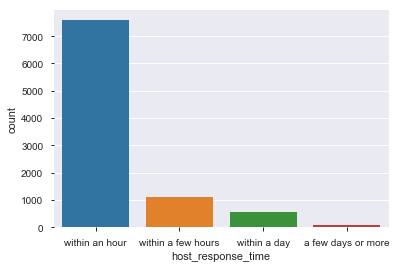

In [58]:
sns.countplot(listings['host_response_time'])

TypeError: can only concatenate str (not "float") to str

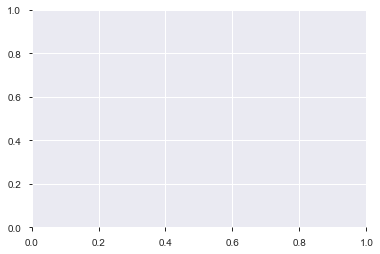

In [59]:
sns.distplot(listings['host_response_rate'], rug = True, kde = False)

In [ ]:
sns.barplot(x = 'host_is_superhost', y = 'price', data = listings, palette = 'Blues')
plt.xlabel("whether host is superhost")

In [ ]:
sns.distplot(listings[listings['host_has_profile_pic'] == 'f']['price'], hist = False, label = 'host does not have profile pic')
sns.distplot(listings[listings['host_has_profile_pic'] == 't']['price'], hist = False, label = 'host has profile pic')

## 1.8 Explore Review Variables
#### Including: number_of_reviews,	number_of_reviews_ltm,	first_review,	last_review,	review_scores_rating,	review_scores_accuracy, etc.

*Expecting* many NA's

In [ ]:
sns.distplot(listings['number_of_reviews'], kde = False, rug = True)

In [ ]:
sns.distplot(np.log(listings['number_of_reviews']+1), kde = False, rug = True)
plt.xlabel('logarithmic number of reviews')

In [ ]:
sns.distplot(listings['review_scores_rating'], kde = False, rug = True)


In [ ]:
fig, axes = plt.subplots(ncols=3, nrows = 2, figsize=(15, 7))
sns.countplot(x="review_scores_accuracy", data = listings, ax=axes[0, 0])
sns.countplot(x="review_scores_cleanliness", data = listings, ax=axes[0, 1])
sns.countplot(x="review_scores_checkin", data = listings, ax=axes[0, 2])
sns.countplot(x="review_scores_communication", data = listings, ax=axes[1, 0])
sns.countplot(x="review_scores_location", data = listings, ax=axes[1, 1])
sns.countplot(x="review_scores_value", data = listings, ax=axes[1, 2])

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows = 2, figsize=(15, 7))
sns.barplot(x="review_scores_accuracy", y = 'price', data = listings, ax=axes[0, 0], palette = 'hls')
sns.barplot(x="review_scores_cleanliness", y = 'price', data = listings, ax=axes[0, 1], palette = 'hls')
sns.barplot(x="review_scores_checkin", y = 'price',data = listings, ax=axes[0, 2], palette = 'hls')
sns.barplot(x="review_scores_communication", y = 'price',data = listings, ax=axes[1, 0], palette = 'hls')
sns.barplot(x="review_scores_location", y = 'price',data = listings, ax=axes[1, 1], palette = 'hls')
sns.barplot(x="review_scores_value", y = 'price', data = listings, ax=axes[1, 2], palette = 'hls')

# 2. Calender Data Preparation

In [ ]:
base_data_url="http://data.insideairbnb.com/united-states/ca/san-diego/2019-11-21/data/"

In [ ]:
calendar=pd.read_csv(base_data_url + "calendar.csv.gz", compression='gzip')

In [ ]:
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
calendar['adjusted_price'] = calendar['adjusted_price'].replace('[\$,]', '', regex=True).astype(float)
calendar['date'] = calendar['date'].astype('datetime64')
calendar.head()

In [ ]:
calendar.shape

In [ ]:
calendar_with_neighbor = calendar.merge(neighborhood_from_listings,how='left', left_on='listing_id', right_on='id').drop(['id','listing_id'],axis=1)
price_vs_date = calendar_with_neighbor.groupby(['date']).mean()
plt.plot(price_vs_date.index,price_vs_date.price)

In [ ]:
calendar_with_neighbor.groupby(['neighbourhood_cleansed','date']).mean()

In [ ]:
price_vs_neighbor = calendar_with_neighbor.groupby(['neighbourhood_cleansed']).mean()

In [ ]:
plt.plot(price_vs_neighbor.index,price_vs_neighbor.price)

In [ ]:
calendar_with_neighbor['month']=calendar_with_neighbor['date'].apply(lambda x: x.month)
price_vs_month = calendar_with_neighbor.groupby(['month']).mean()
plt.plot(price_vs_month.index,price_vs_month.price)

In [ ]:
calendar_with_neighbor.groupby(['neighbourhood_cleansed','month']).mean()

In [ ]:
def month_to_season(m):
    if m in [12,1,2]: return 4
    elif m in [3,4,5]: return 1
    elif m in [6,7,8]: return 2
    else: return 3
    
calendar_with_neighbor['season']=calendar_with_neighbor['month'].apply(lambda x: month_to_season(x))

In [ ]:
price_vs_season = calendar_with_neighbor.groupby(['season']).mean()

In [ ]:
plt.plot(price_vs_season.index,price_vs_season.price)

In [ ]:
calendar_with_neighbor.drop(['month'], axis=1).groupby(['neighbourhood_cleansed','season']).mean()

In [ ]:
calendar['available'] = calendar['available'].map(lambda x: 1 if x == 't' else 0)

In [ ]:
calendar_by_year = calendar.groupby('listing_id').mean()

In [ ]:
new_listing = listings.merge(calendar_by_year, left_on = 'id', right_index = True, how='left')

In [ ]:
new_listing.head()